In [67]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from utils import ProgBar

# Parameters

In [68]:
h = 0.01
k = 0.1
Db = 0.0001
Dn = 0.0001
phi = 0.2
ksi = 0.0
cp = 0.154
lambd_nb = 40
mi_n = 0.2
lambd_bn = 0.1
X_nb = 0.0001
y_n = 0.1
C_nmax = 0.55

x_dom = (0, 1)
y_dom = (0, 1)
t_dom = (0, 10)

size_x = int(((x_dom[1] - x_dom[0]) / (h)))
size_y = int(((y_dom[1] - y_dom[0]) / (h)))
size_tt = int(((t_dom[1] - t_dom[0]) / (k)))

x = np.linspace((x_dom[1], x_dom[0]), size_x)
y = np.linspace((y_dom[1], y_dom[0]), size_y)
t = np.linspace((t_dom[1], t_dom[0]), size_tt)

print("Size x = {:d}, y = {:d} \n ".format(size_x, size_y))

print(
    "Steps in time = {:d}\nSteps in space_x = {:d}\nSteps in space_y = {:d}\n".format(
        size_tt,
        size_x,
        size_y,
    )
)

CFL = ((Db * k) / ((2 * (h * h))))

print("CFL: ",CFL)
if CFL >= 1:
    print("Criterio não satisfeito")

Size x = 100, y = 100 
 
Steps in time = 100
Steps in space_x = 100
Steps in space_y = 100

CFL:  0.05


# Model definition

In [69]:
class PINN(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.net = torch.nn.Sequential(
            nn.Linear(3, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        out = self.net(x)
        return out

In [70]:
def gerenate_training(num_points):
    x = torch.rand(num_points, 1, requires_grad=True)
    y = torch.rand(num_points, 1, requires_grad=True)
    t = torch.rand(num_points, 1, requires_grad=True)

    return x, y, t

In [71]:
def initial_condition(x, y):

    Cl = torch.zeros_like(x)

    Cp = torch.sin(torch.pi * x) * torch.sin(torch.pi * y)

    for i, (xx, yy) in enumerate(zip(x, y)):
        if ((xx >= 0.5) and (xx <= 0.58)) and ((yy >= 0.5) and (yy <= 0.58)):
            Cp[i] = 0.2


    return torch.cat([Cl, Cp], dim=1)

In [72]:
def gerenate_boundary_training_data(num_points, direction="x"):

    x_boundary = torch.tensor([0, 1]).repeat(num_points // 2)
    y_boundary = torch.rand(num_points, requires_grad=True)

    if direction == "y":
        x_boundary, y_boundary = y_boundary, x_boundary
        n_boundary = torch.tensor([0, -1, 0, 1])
        n_boundary = n_boundary.repeat(num_points // 2)

    else:
        n_boundary = torch.tensor([-1, 0, 1, 0])
        n_boundary = n_boundary.repeat(num_points // 2)

    t = torch.rand(num_points, 1, requires_grad=True)

    return (
        x_boundary.view(-1, 1),
        y_boundary.view(-1, 1),
        t.view(-1, 1),
        n_boundary.view(-1, 2),
    )

In [73]:
def boundary_condition(x_b, y_b, t_b, n, model, custom_value=0):
    input_data = torch.cat([x_b, y_b, t_b], dim=1)

    Cp, Cl = model(input_data).tensor_split(2, dim=1)

    ny, nx = n.tensor_split(2, dim=1)

    if nx[0].item() != 0:
        dCp_dx = torch.autograd.grad(
            Cp,
            x_b,
            grad_outputs=torch.ones_like(Cp),
            create_graph=True,
            retain_graph=True,
        )
        dCl_dx = torch.autograd.grad(
            Cl,
            x_b,
            grad_outputs=torch.ones_like(Cl),
            create_graph=True,
            retain_graph=True,
        )

        Cl_boundary = (
            torch.mul(((Dn * dCl_dx[0]) - X_nb * torch.mul(Cl, dCp_dx[0])), nx)
            - custom_value
        )
        Cp_boundary = torch.mul((Db * dCp_dx[0]), nx) - custom_value

        return torch.cat([Cl_boundary, Cp_boundary], dim=1)

    else:
        dCp_dy = torch.autograd.grad(
            Cp,
            y_b,
            grad_outputs=torch.ones_like(Cp),
            create_graph=True,
            retain_graph=True,
        )
        dCl_dy = torch.autograd.grad(
            Cl,
            y_b,
            grad_outputs=torch.ones_like(Cl),
            create_graph=True,
            retain_graph=True,
        )

        Cl_boundary = (
            torch.mul(((Dn * dCl_dy[0]) - X_nb * torch.mul(Cl, dCp_dy[0])), ny)
            - custom_value
        )
        Cp_boundary = torch.mul((Db * dCp_dy[0]), ny) - custom_value

        return torch.cat([Cl_boundary, Cp_boundary], dim=1)

In [74]:
def pde(x, y, t, model):
    input_data = torch.cat([x, y, t], dim=1)

    Cp, Cl = model(input_data).tensor_split(2, dim=1)

    # Calculating Cp value

    dCp_dx, dCp_dy = torch.autograd.grad(
        Cp,
        [x, y],
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )

    dCp_dx_2 = torch.autograd.grad(
        dCp_dx,
        x,
        grad_outputs=torch.ones_like(dCp_dx),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCp_dy_2 = torch.autograd.grad(
        dCp_dy,
        y,
        grad_outputs=torch.ones_like(dCp_dy),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCp_dt = torch.autograd.grad(
        Cp,
        t,
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )[0]

    qb = cp * Cp
    rb = lambd_nb * torch.mul(Cl, Cp)

    Cp_eq = Db * (dCp_dx_2 + dCp_dy_2) - rb + qb - dCp_dt

    # Calculating Cl value

    dCl_dx, dCl_dy = torch.autograd.grad(
        Cl,
        [x, y],
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )

    dCl_dx_2 = torch.autograd.grad(
        dCl_dx,
        x,
        grad_outputs=torch.ones_like(dCl_dx),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCl_dy_2 = torch.autograd.grad(
        dCl_dy,
        y,
        grad_outputs=torch.ones_like(dCl_dy),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCl_dt = torch.autograd.grad(
        Cl,
        t,
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )[0]

    qn = y_n * torch.mul(Cp, (C_nmax - Cl))
    rn = lambd_bn * torch.mul(Cl, Cp) + mi_n * Cl

    Cl_eq = (
        Dn * (dCl_dx_2 + dCl_dy_2)
        - X_nb
        * (
            (torch.mul(dCl_dx, dCp_dx) + torch.mul(Cl, dCp_dx_2))
            + (torch.mul(dCl_dy, dCp_dy) + torch.mul(Cl, dCp_dy_2))
        )
        - rn
        + qn
    ) - dCl_dt
    
    return torch.cat([Cl_eq, Cp_eq], dim=1)

In [75]:
def train_PINN(model, num_iterations, num_points):

    # Initializing optimator
    adam = optim.Adam(model.parameters(), betas=(0.8, 0.999), lr=1e-4)

    adam.zero_grad()

    # Declaring exponential decay

    decay_rate = 0.985

    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=adam, gamma=decay_rate)

    C_initial_loss_it = []
    C_boundary_loss_it = []
    C_loss_it = []

    bar = ProgBar(num_iterations, "Rodando épocas...")

    for it in range(num_iterations):

        x, y, t = gerenate_training(num_points)

        t_initial = torch.zeros_like(t)
        C_initial = initial_condition(x, y)

        x_b_x, y_b_x, t_b_x, n_x = gerenate_boundary_training_data(num_points)

        x_b_y, y_b_y, t_b_y, n_y = gerenate_boundary_training_data(
            num_points, direction="y"
        )

        C_boundary_x = boundary_condition(x_b_x, y_b_x, t_b_x, n_x, model)

        C_boundary_y = boundary_condition(x_b_y, y_b_y, t_b_y, n_y, model)

        C = pde(x, y, t, model)

        C_initial_pred = model(torch.cat([x, y, t_initial], dim=1))

        C_initial_loss = nn.MSELoss()(C_initial, C_initial_pred)

        C_boundary_loss = nn.MSELoss()(
            C_boundary_x, torch.zeros_like(C_boundary_x)
        ) + nn.MSELoss()(C_boundary_y, torch.zeros_like(C_boundary_y))

        C_loss = nn.MSELoss()(C, torch.zeros_like(C))

        loss = C_initial_loss + C_boundary_loss + C_loss

        loss.backward()

        C_boundary_loss_it.append(C_boundary_loss.item())
        C_loss_it.append(C_loss.item())
        C_initial_loss_it.append(C_initial_loss.item())

        adam.step()

        lr_scheduler.step()

        bar.update()

    return C_boundary_loss_it, C_initial_loss_it, C_loss_it

In [76]:
model = PINN()

n_iterations = 10000

C_boundary_loss_it, C_initial_loss_it, C_loss_it = train_PINN(
    model, n_iterations, size_x
)

Rodando épocas...
[--------------------------------------------------] 100.00% - 10000 of 10000

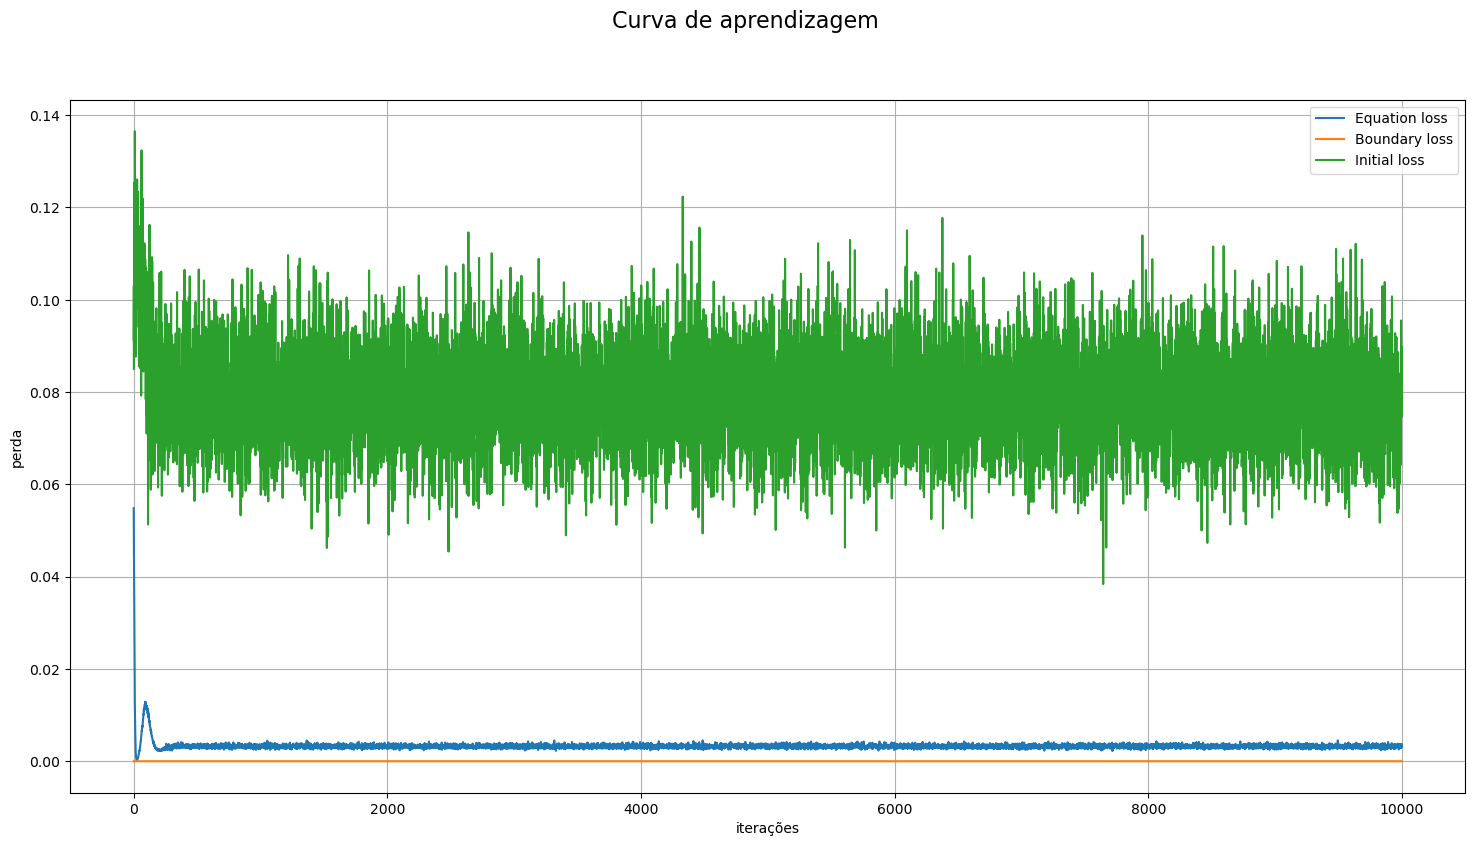

In [77]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

fig = plt.figure(figsize=[18, 9])

fig.suptitle('Curva de aprendizagem', fontsize=16)


# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")
ax.plot(range(len(C_loss_it)),C_loss_it,label="Equation loss")
ax.plot(range(len(C_boundary_loss_it)),C_boundary_loss_it,label="Boundary loss")
ax.plot(range(len(C_initial_loss_it)),C_initial_loss_it,label="Initial loss")
# ax.set_yscale("log")
ax.grid()
ax.legend()


plt.show()

In [78]:
C_boundary_loss_it[-1]+C_initial_loss_it[-1]+C_loss_it[-1]

0.08500348660921893

In [79]:
t_vals = torch.linspace(0, 1, size_tt)
x_vals = torch.linspace(0, 1, size_x)
y_vals = torch.linspace(0, 1, size_x)
X, Y = torch.meshgrid(x_vals, y_vals)


Cl_t = []
for t in t_vals:
    with torch.no_grad():

        t_val = torch.ones_like(X) * t  # specify time

        input_data = torch.stack([X.flatten(), Y.flatten(), t_val.flatten()], dim=1)

        solution = model(input_data)

        Cl,Cp = solution.tensor_split(2, dim=1)
        Cl = Cl.reshape(X.shape, Y.shape)
        Cp = Cp.reshape(X.shape, Y.shape)

        Cl_t.append(Cl)


In [80]:

Cl,Cp = solution.tensor_split(2, dim=1)
Cl = Cl.reshape(X.shape, Y.shape)
Cp = Cp.reshape(X.shape, Y.shape)

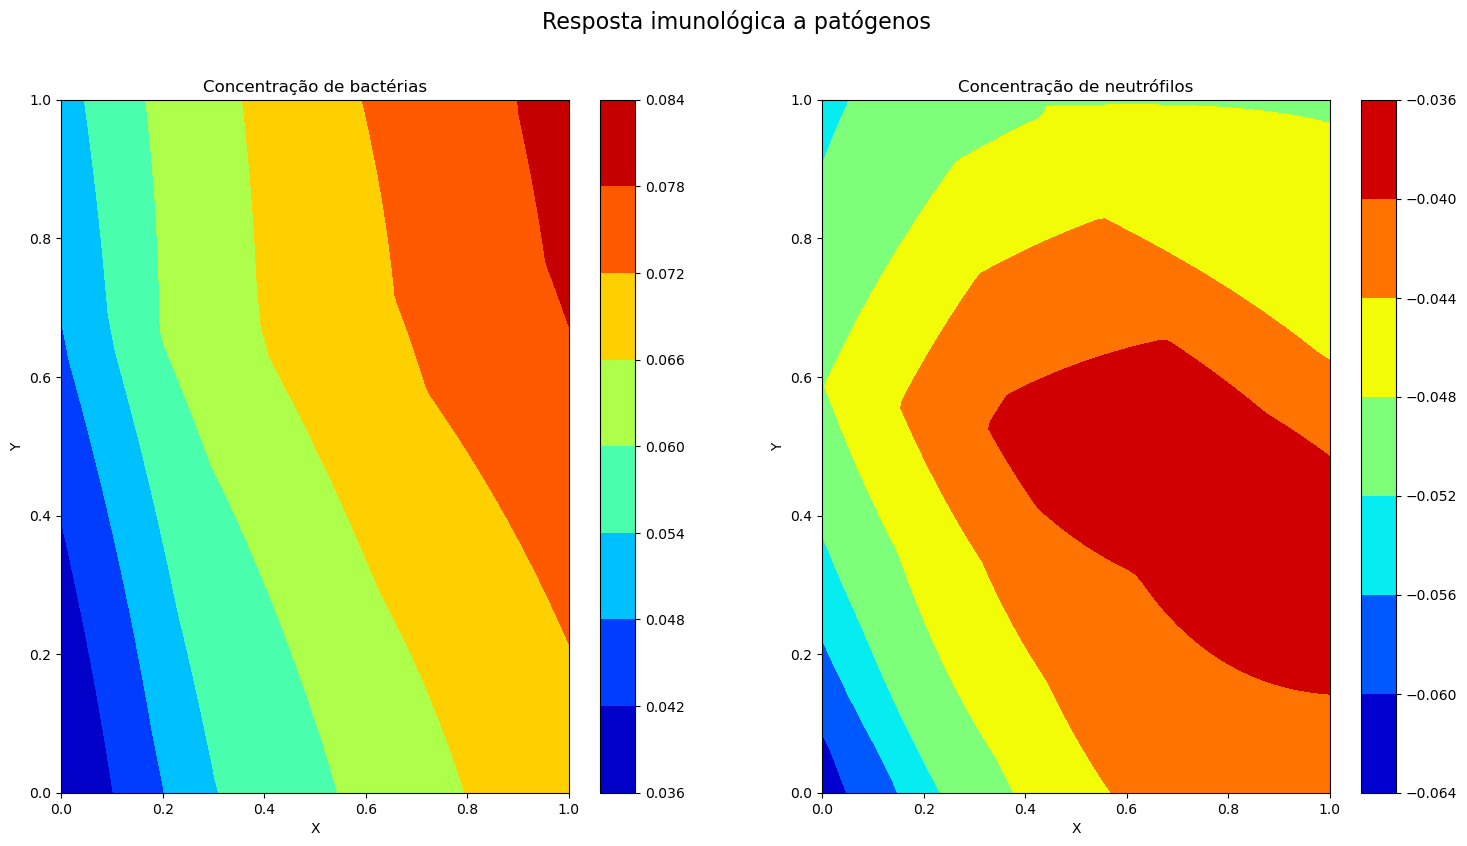

In [83]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

fig = plt.figure(figsize=[18, 9])

fig.suptitle('Resposta imunológica a patógenos', fontsize=16)

X, Y = np.meshgrid(x_vals.numpy(),y_vals.numpy())

# vmin = 0
# vmax = np.max([torch.max(Cp),torch.max(Cl)])

# Plotango 3D
ax = fig.add_subplot(1, 2, 1)

contour = ax.contourf(X, Y, Cp, cmap="jet")
ax.set_title("Concentração de bactérias")
ax.set_xlabel("X")
ax.set_ylabel("Y")
colobar = fig.colorbar(contour)

# Plotando 2D

ax = fig.add_subplot(1, 2, 2)

contour = ax.contourf(X, Y, Cl_t[0], cmap="jet")
ax.set_title("Concentração de neutrófilos")
ax.set_xlabel("X")
ax.set_ylabel("Y")

colobar = fig.colorbar(contour)

plt.show()